# CLASS ACTIVATION MAP

In [1]:
import urllib, os
import tarfile
import numpy as np
import scipy.misc
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v1
%matplotlib inline
print ("PACKAGES LOADED")

PACKAGES LOADED


## DOWNLOAD PRETRAINED NET

In [2]:
# MAKE PATH IF NECESSARY 
dirpath = "data/"
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
# DOWNLOAD 
urlpath = "http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz"
zname   = "data/resnet_v1_50_2016_08_28.tar.gz"
if not os.path.exists(zname):
    print ("DOWNLOADING %s..." % (zname))
    urllib.urlretrieve(urlpath, zname)
    print ("DONE")
else:
    print ("%s ALREADY EXISTS" % (zname))

data/resnet_v1_50_2016_08_28.tar.gz ALREADY EXISTS


## UNZIP CKPT

In [3]:
fname = "data/resnet_v1_50_2016_08_28"
if not os.path.exists(fname):
    print ("EXTRACTING %s..." % (fname))
    tar = tarfile.open(zname, "r:gz")
    tar.extractall(path=fname)
    tar.close()
    print ("DONE.")
else:
    print ("%s ALREADY EXIST" % (fname))

data/resnet_v1_50_2016_08_28 ALREADY EXIST


## UTILITY FUNCTIONS

In [4]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))
print ("UTILITY FUNCTIONS")

UTILITY FUNCTIONS


## LOAD CALTECH 101

In [5]:
cwd = os.getcwd()
path = cwd + "/data/101_ObjectCategories"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
imgs = []
labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    if i == 0:
        continue
    for f in os.listdir(path + "/" + category):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_exts:
            continue
        fullpath = os.path.join(path + "/" + category, f)
        img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
        imgs.append(img) # NORMALIZE IMAGE 
        label_curr = np.zeros((ncategories))
        label_curr[i] = 1
        labels.append(label_curr)
print ("Num imgs: %d" % (len(imgs)))
print ("Num labels: %d" % (len(labels)) )

[102] CATEGORIES ARE IN 
 /home/sj/notebooks/github/advanced-tensorflow/cam/data/101_ObjectCategories
Num imgs: 8677
Num labels: 8677


## DIVIDE THE DATASET INTO TWO

In [6]:
ndata = len(imgs)
ntrain = int(ndata*0.7) # WILL USE 70% FOR TRAINING
ntest = ndata-ntrain
randidx = np.random.permutation(ndata)
trainidx = randidx[:ntrain]
testidx = randidx[ntrain+1:]
train_imgs = [imgs[idx] for idx in trainidx]
train_labels = [labels[idx] for idx in trainidx]
test_imgs = [imgs[idx] for idx in testidx]
test_labels = [labels[idx] for idx in testidx]
# TENSORIZE DATA 
train_imgs_tensor = np.stack(train_imgs, axis=0)
train_labels_tensor = np.stack(train_labels, axis=0)
test_imgs_tensor = np.stack(test_imgs, axis=0)
test_labels_tensor = np.stack(test_labels, axis=0)
print "Num train_imgs: %d" % (len(train_imgs))
print "Num test_imgs: %d" % (len(test_imgs))
print_np(train_imgs_tensor, "train_imgs_tensor")
print_np(train_labels_tensor, "train_labels_tensor")
print_np(test_imgs_tensor, "test_imgs_tensor")
print_np(test_labels_tensor, "test_labels_tensor")
# REMOVE LISTS FROM MEMORY
del train_imgs, train_labels, test_imgs, test_labels

Num train_imgs: 6073
Num test_imgs: 2603
Type of 'train_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'train_imgs_tensor' is (6073, 224, 224, 3)
Type of 'train_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'train_labels_tensor' is (6073, 102)
Type of 'test_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'test_imgs_tensor' is (2603, 224, 224, 3)
Type of 'test_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'test_labels_tensor' is (2603, 102)


## PLOT DATASET

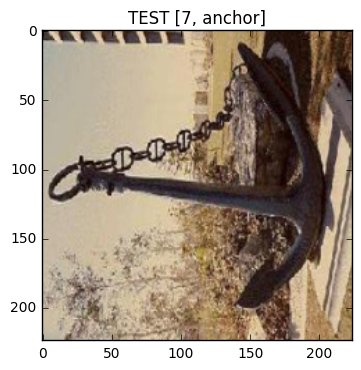

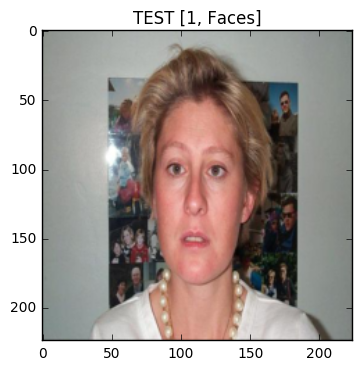

In [7]:
randidx = np.sort(np.random.randint(ntrain, size=2))
for i, j in enumerate(randidx):
    curr_img = train_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(train_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TRAIN [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()
randidx = np.sort(np.random.randint(ntest, size=2))
for i, j in enumerate(randidx):
    curr_img = test_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(test_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TEST [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()

## OPEN SESSION

In [8]:
sess = tf.Session()
print ("OPEN SESSION")

OPEN SESSION


## RESNET_V1_50 

In [9]:
x = tf.placeholder(shape=[None, 224, 224, 3], dtype=tf.float32)
with slim.arg_scope(resnet_v1.resnet_arg_scope()):
    mean = tf.constant([123.68, 116.779, 103.939],
        dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    im_centered = x - mean
    net, end_points = resnet_v1.resnet_v1_50(inputs=im_centered, num_classes=1000)
    b1 = end_points['resnet_v1_50/block1']

variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
restorer = tf.train.Saver(variables_to_restore)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
restorer.restore(sess, fname+"/resnet_v1_50.ckpt") 
print ("RESNET V1-50 RESTORED")

RESNET V1-50 RESTORED


## DEFINE NETWORK

In [10]:
# PARAMETERS
n_output = ncategories
y = tf.placeholder('float', [None, n_output])
kr = tf.placeholder('float')
weights = {
    'wc': tf.Variable(tf.truncated_normal([3, 3, 256, 512], stddev=0.1)),
    'out': tf.Variable(tf.random_normal([512, n_output], stddev=0.1))
}
biases = {
    'bc': tf.Variable(tf.random_normal([512], stddev=0.1)),
    'out': tf.Variable(tf.random_normal([n_output], stddev=0.1))
}
# NETWORK
def cam(_x, _W, _b, _kr):
    conv = tf.nn.conv2d(_x, _W['wc'], strides=[1, 1, 1, 1], padding='SAME')
    conv_relu = tf.nn.relu(tf.nn.bias_add(conv, _b['bc'])) 
    conv_dr = tf.nn.dropout(conv_relu, _kr)
    gap = tf.nn.avg_pool(conv_dr, ksize=[1, 28, 28, 1], strides=[1, 28, 28, 1],
            padding='SAME')
    gap_dr = tf.nn.dropout(gap, _kr)
    gap_vec = tf.reshape(gap_dr, [-1, _W['out'].get_shape().as_list()[0]])
    out = tf.add(tf.matmul(gap_vec, _W['out']), _b['out'])
    ret = {'conv_relu': conv_relu, 'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}
    return ret
print ("NETWORK READY")

NETWORK READY


## FUNCTIONS

In [11]:
gap  = cam(b1, weights, biases, kr)['conv_relu']
pred = cam(b1, weights, biases, kr)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3) 
print ("FUNCTIONS READY")

FUNCTIONS READY


## TRAIN THE NETWORK

[0/200] cost: 5.7336 train_acc: 0.273 test_acc: 0.273
PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 81  (scissors)


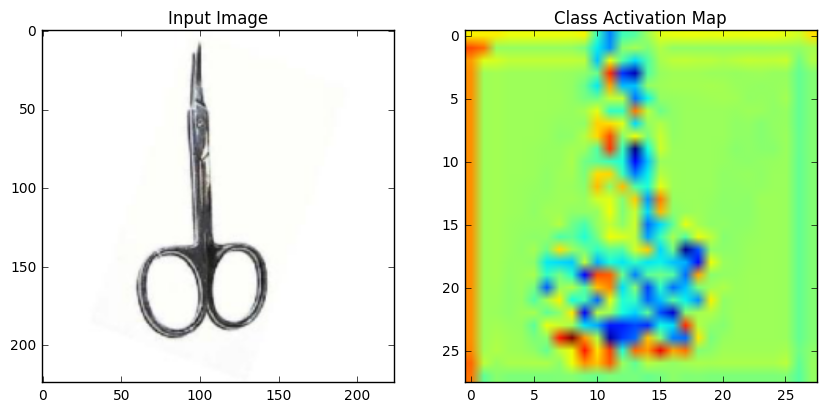

[5/200] cost: 2.8310 train_acc: 0.492 test_acc: 0.422
[10/200] cost: 2.2447 train_acc: 0.547 test_acc: 0.500
[15/200] cost: 1.9127 train_acc: 0.578 test_acc: 0.492
[20/200] cost: 1.6705 train_acc: 0.711 test_acc: 0.625
PREDICTED CLASS : 3  (Leopards)
     TRUE CLASS : 2  (Faces_easy)


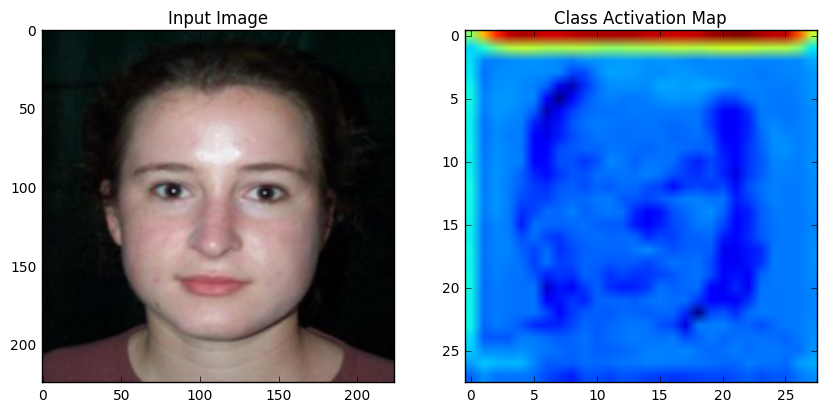

[25/200] cost: 1.4168 train_acc: 0.703 test_acc: 0.523
[30/200] cost: 1.2088 train_acc: 0.797 test_acc: 0.547
[35/200] cost: 1.0247 train_acc: 0.820 test_acc: 0.625
[40/200] cost: 0.8917 train_acc: 0.836 test_acc: 0.562
PREDICTED CLASS : 31  (cup)
     TRUE CLASS : 4  (Motorbikes)


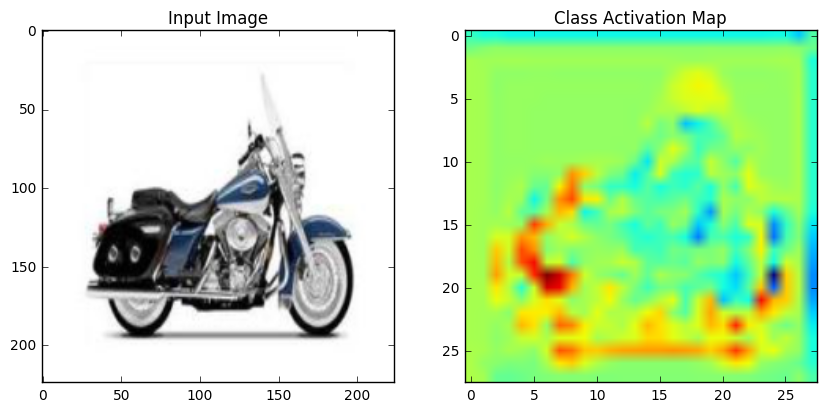

[45/200] cost: 0.7302 train_acc: 0.852 test_acc: 0.547
[50/200] cost: 0.6285 train_acc: 0.945 test_acc: 0.703
[55/200] cost: 0.5292 train_acc: 0.922 test_acc: 0.648
[60/200] cost: 0.4387 train_acc: 0.977 test_acc: 0.562
PREDICTED CLASS : 31  (cup)
     TRUE CLASS : 71  (panda)


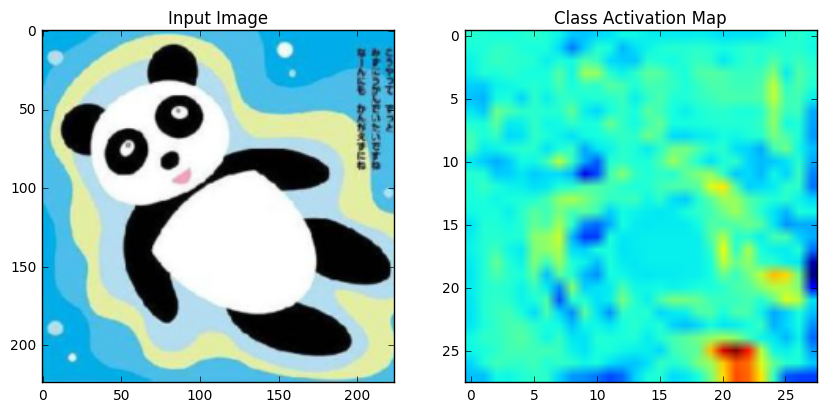

[65/200] cost: 0.3721 train_acc: 0.977 test_acc: 0.656
[70/200] cost: 0.3250 train_acc: 0.992 test_acc: 0.578
[75/200] cost: 0.2679 train_acc: 0.992 test_acc: 0.695
[80/200] cost: 0.2558 train_acc: 1.000 test_acc: 0.617
PREDICTED CLASS : 7  (anchor)
     TRUE CLASS : 20  (car_side)


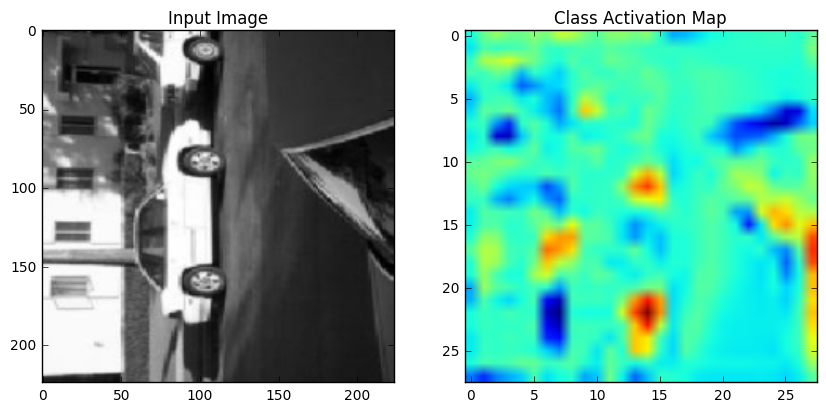

[85/200] cost: 0.1974 train_acc: 0.992 test_acc: 0.703
[90/200] cost: 0.2122 train_acc: 0.984 test_acc: 0.625
[95/200] cost: 0.1733 train_acc: 1.000 test_acc: 0.633
[100/200] cost: 0.1499 train_acc: 1.000 test_acc: 0.648
PREDICTED CLASS : 35  (dragonfly)
     TRUE CLASS : 2  (Faces_easy)


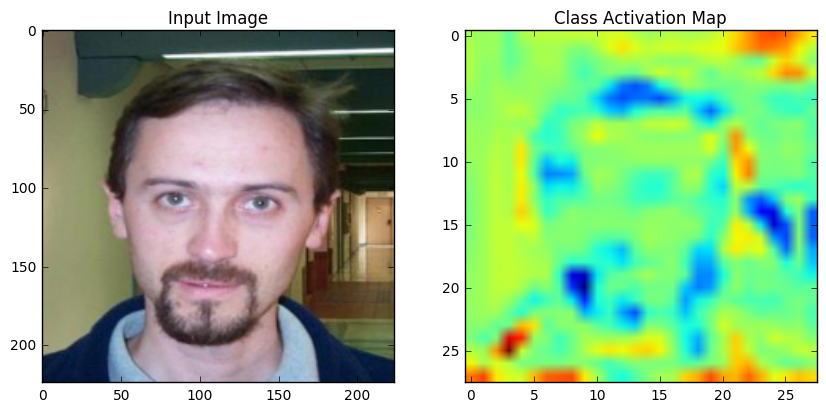

[105/200] cost: 0.1436 train_acc: 0.992 test_acc: 0.625
[110/200] cost: 0.1438 train_acc: 1.000 test_acc: 0.586
[115/200] cost: 0.1252 train_acc: 1.000 test_acc: 0.641
[120/200] cost: 0.1085 train_acc: 0.992 test_acc: 0.625
PREDICTED CLASS : 95  (watch)
     TRUE CLASS : 95  (watch)


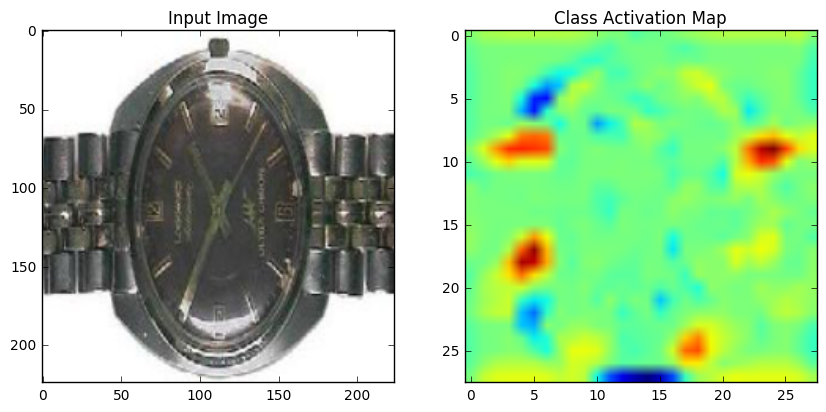

[125/200] cost: 0.0770 train_acc: 1.000 test_acc: 0.688
[130/200] cost: 0.1103 train_acc: 1.000 test_acc: 0.625
[135/200] cost: 0.0799 train_acc: 1.000 test_acc: 0.562
[140/200] cost: 0.0783 train_acc: 1.000 test_acc: 0.617
PREDICTED CLASS : 2  (Faces_easy)
     TRUE CLASS : 2  (Faces_easy)


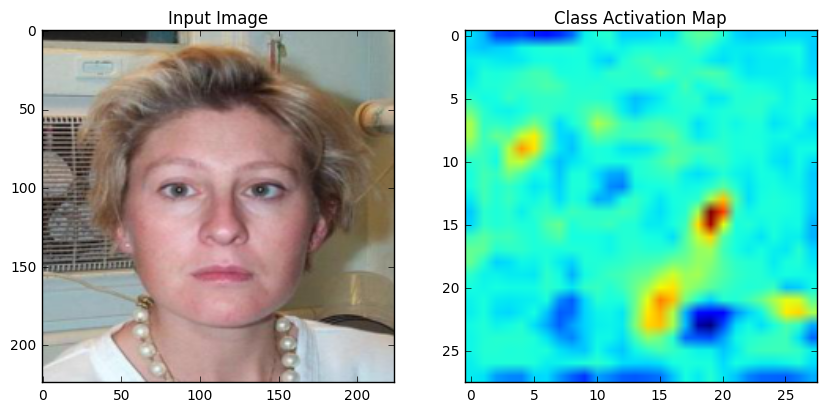

[145/200] cost: 0.0888 train_acc: 1.000 test_acc: 0.625
[150/200] cost: 0.1176 train_acc: 1.000 test_acc: 0.641
[155/200] cost: 0.0665 train_acc: 1.000 test_acc: 0.703
[160/200] cost: 0.0628 train_acc: 1.000 test_acc: 0.695
PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 4  (Motorbikes)


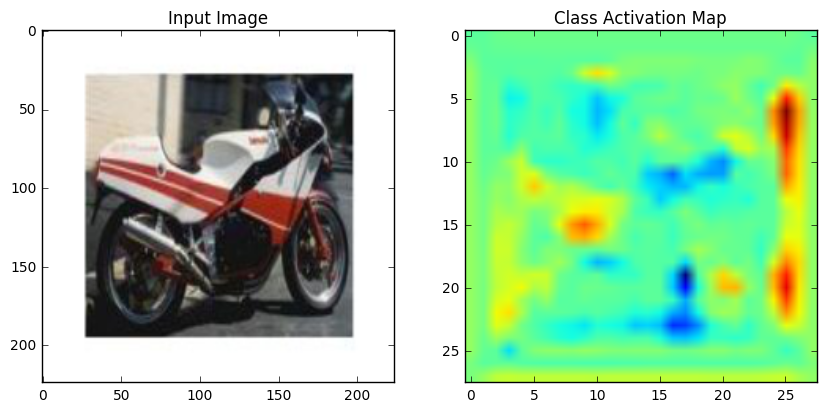

[165/200] cost: 0.0761 train_acc: 1.000 test_acc: 0.617
[170/200] cost: 0.0510 train_acc: 1.000 test_acc: 0.664
[175/200] cost: 0.0739 train_acc: 1.000 test_acc: 0.695
[180/200] cost: 0.0631 train_acc: 1.000 test_acc: 0.633
PREDICTED CLASS : 7  (anchor)
     TRUE CLASS : 21  (ceiling_fan)


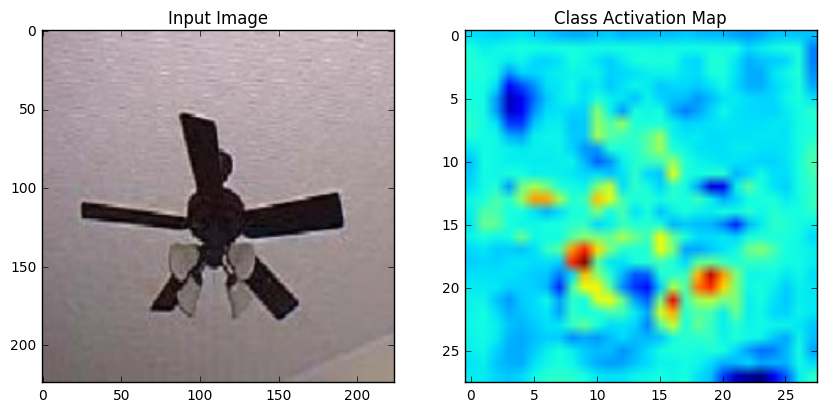

[185/200] cost: 0.0630 train_acc: 1.000 test_acc: 0.727
[190/200] cost: 0.0517 train_acc: 1.000 test_acc: 0.648
[195/200] cost: 0.0643 train_acc: 1.000 test_acc: 0.648
OPTIMIZATION FINISHED


In [12]:
# SOME PARAMETERS
training_epochs = 200
batch_size   = 128
total_batch  = (ntrain // batch_size) + 1
disp_step    = 5
plot_step    = 20 

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)
for epoch in range(training_epochs):
    avg_cost = 0.
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_x = train_imgs_tensor[randidx, :, :, :]
        batch_y = train_labels_tensor[randidx, :]
        feeds_iter = {x: batch_x, y: batch_y, kr: 0.7}
        _, c = sess.run([optm, cost], feed_dict=feeds_iter)
        avg_cost += c 
    avg_cost = avg_cost / total_batch
    if epoch % disp_step == 0:
        feeds_train = {x: batch_x, y: batch_y, kr: 1.}
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_idx = np.random.randint(len(test_imgs_tensor), size=128)
        test_imgs_temp = test_imgs_tensor[test_idx, :, :, :]
        test_labels_temp = test_labels_tensor[test_idx, :]
        feeds_test = {x: test_imgs_temp, y: test_labels_temp, kr: 1.}
        test_acc = sess.run(accr, feed_dict=feeds_test)
        print ("[%d/%d] cost: %.4f train_acc: %.3f test_acc: %.3f" 
               % (epoch, training_epochs, avg_cost, train_acc, test_acc))
        saver.save(sess, 'data/nets/cam_resnet_caltech101.ckpt', global_step=epoch)        
    if epoch % plot_step == 0:
        # PLOT
        ntest = test_imgs_tensor.shape[0]
        randidx = np.random.randint(ntest, size=1)
        for idx in randidx:
            testimg = test_imgs_tensor[idx, :, :, :]
            testimg = testimg.reshape((-1,) + testimg.shape)
            testlabel = np.argmax(test_labels_tensor[idx, :])
            
            cam_testfeat, cam_outval, cam_weights = sess.run([gap, pred, weights['out']],
                                feed_dict={x: testimg, kr: 1.})
            predlabel   = np.argmax(cam_outval)
            predweights = cam_weights[:, predlabel]
            camsum = np.zeros((28, 28))
            for i in xrange(512): 
                camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]
            camavg = camsum / 512.

            print "PREDICTED CLASS : %d  (%s)" % (predlabel, categories[predlabel])
            print "     TRUE CLASS : %d  (%s)" % (testlabel, categories[testlabel])
            # PLOT
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(1,2,1)     
            ax1.imshow(testimg[0])
            ax1.set_title("Input Image")
            ax2 = fig1.add_subplot(1,2,2)     
            im2 = ax2.imshow(camavg, origin='upper')
            ax2.set_title("Class Activation Map")
            # plt.colorbar(im2, ax=ax2)
            plt.show()
print ("OPTIMIZATION FINISHED")

## CHECK CLASS ACTIVATION MAP

In [13]:
cam_testfeat

array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         ..., 
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.    